In [3]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model, image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pathlib
import cv2
import os

### Paths

In [5]:
images_path = '../../../Dataset/img_celeba_cropped'
identity_path = '../../../Dataset/identity_CelebA.txt'
attributes_path = '../../../Dataset/list_attr_celeba.txt'

### Hyperparameters

In [6]:
images_num=500

train_size=0.6
test_val_proportion=0.5

image_shape=(224, 224, 3)

batch_size=32
lr=0.01

## Creating pairs

In [7]:
celeb_identity = pd.read_csv(identity_path, sep = " ", names=["image", "identity"])
celeb_identity["identity"] = celeb_identity["identity"].astype("string")

celeb_attrs = pd.read_csv(attributes_path, sep = "\s+")

In [8]:
def get_balanced_pair(column:str, pairing_column:str, df=celeb_identity):
    # getting random identity from the provided column to use for balanced pair
    random_id = df[column].sample(1, replace=True).to_string(index=False)
    containing_id_list = df.loc[df[column] == random_id][pairing_column].sample(2, replace=True).to_list()
    
    # random pictures for pair generation
    df_without_id = df.loc[df[pairing_column] != random_id]
    negative = df[pairing_column].sample(1, replace=False).to_list()
    
    return [[containing_id_list[0], containing_id_list[1], 1], [containing_id_list[0], negative[0], 0]]

In [9]:
balanced_pairs = []

for record in range(images_num):
    pair = get_balanced_pair("identity", "image")
    balanced_pairs.append(pair[0])
    balanced_pairs.append(pair[1])
    
df = pd.DataFrame(balanced_pairs, columns =['left', 'right', 'label'])
df['left'] = images_path + '/' + df['left']
df['right'] = images_path + '/' + df['right']

In [10]:
df.shape
df.head()

,left,right,label
0,../../../Dataset/img_celeba_cropped/092155.jpg,../../../Dataset/img_celeba_cropped/147698.jpg,1
1,../../../Dataset/img_celeba_cropped/092155.jpg,../../../Dataset/img_celeba_cropped/098441.jpg,0
2,../../../Dataset/img_celeba_cropped/147647.jpg,../../../Dataset/img_celeba_cropped/029086.jpg,1
3,../../../Dataset/img_celeba_cropped/147647.jpg,../../../Dataset/img_celeba_cropped/084465.jpg,0
4,../../../Dataset/img_celeba_cropped/158653.jpg,../../../Dataset/img_celeba_cropped/156888.jpg,1


### Create test train val split

In [11]:
X_train, X_rem, y_train, y_rem = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], train_size=train_size, random_state = 101, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=test_val_proportion)

In [12]:
print('=====Training=====')
print(X_train.shape)
print(y_train.shape)

print('=====Validation=====')
print(X_val.shape)
print(y_val.shape)

print('=====Testing=====')
print(X_test.shape)
print(y_val.shape)

=====Training=====
(600, 2)
(600, 1)
=====Validation=====
(200, 2)
(200, 1)
=====Testing=====
(200, 2)
(200, 1)


### Loading pairs into TF Dataset

In [20]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.expand_dims(img, axis=0)
    img = tf.reshape(img,(224,224,3))
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [94]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    feature_ds = feature_ds.map(preprocessing)
    labels_ds = labels_ds.map(label_preprocessing)
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [51]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

## NN model

In [52]:
left_input = layers.Input(shape=(224, 224, 3), name='left_input')
right_input = layers.Input(shape=(224, 224, 3), name='right_input')

### ResNet50 model

In [25]:
resnet_left=ResNet50(
    input_tensor=left_input,
    include_top=False,
    input_shape=image_shape,
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in resnet_left.layers[0:-1]:
    layer.trainable = False

    
output_layer_left = resnet_left.output
    
model_left = Model(left_input, outputs=output_layer_left, name='resnet50_1')

In [26]:
resnet_right=ResNet50(
    input_tensor=right_input,
    include_top=False,
    input_shape=image_shape,
    pooling='avg',
    weights='imagenet',
    classes=2)

for layer in resnet_right.layers[0:-1]:
    layer.trainable = False
    
for layer in resnet_right.layers:
    layer._name = layer.name + str('_2')

    
output_layer_right = resnet_right.output
    
model_right = Model(right_input, outputs=output_layer_right, name='resnet50_2')

### Merging resnet branches layers

In [27]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

In [28]:
#merged = layers.subtract([model_left.output, model_right.output])
model = layers.Lambda(euclidean_distance, name="merge")([model_left.output, model_right.output])

model = layers.Flatten()(model)

model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(.2)(model)

model = layers.Dense(32, activation='relu')(model)

model = layers.Dense(1, activation='sigmoid')(model)

model = Model(inputs = [left_input, right_input], outputs = model)

In [29]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

In [30]:
model.compile(optimizer=Adam(learning_rate=lr), loss=contrastive_loss_with_margin(margin=1.0), metrics=['accuracy'])

In [31]:
#plot_model(model, show_shapes=True)
#model.summary()

In [32]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


2022-11-27 15:59:44.375622: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 15:59:45.985325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.5033

2022-11-27 15:59:53.019121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 12s 483ms/step - loss: 0.2531 - accuracy: 0.5033 - val_loss: 0.2500 - val_accuracy: 0.4850
Epoch 2/5
19/19 [==============================] - 7s 359ms/step - loss: 0.2484 - accuracy: 0.4533 - val_loss: 0.2494 - val_accuracy: 0.4700
Epoch 3/5
19/19 [==============================] - 7s 352ms/step - loss: 0.2467 - accuracy: 0.4450 - val_loss: 0.2491 - val_accuracy: 0.4400
Epoch 4/5
19/19 [==============================] - 7s 360ms/step - loss: 0.2446 - accuracy: 0.4417 - val_loss: 0.2485 - val_accuracy: 0.4650
Epoch 5/5
19/19 [==============================] - 7s 359ms/step - loss: 0.2422 - accuracy: 0.4183 - val_loss: 0.2481 - val_accuracy: 0.4900


### Performance metrics

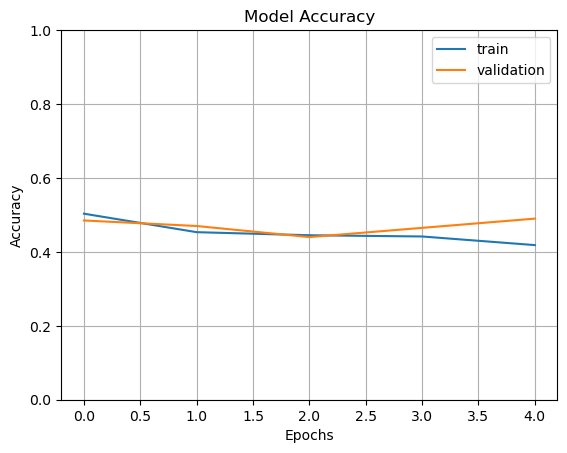

In [95]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=1)
plt.grid()

plt.show()

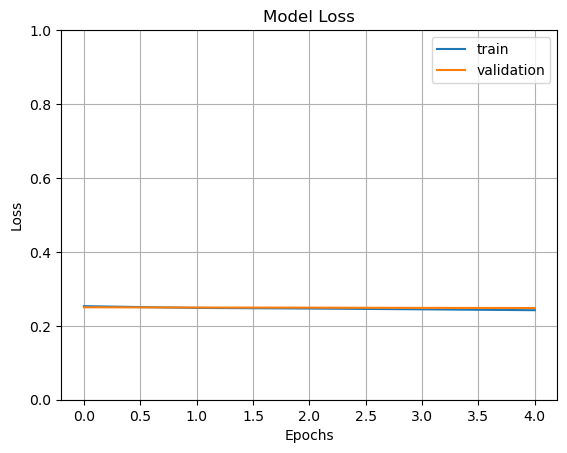

In [96]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.axis(ymin=0,ymax=1)
plt.grid()

plt.show()

### Predictions

In [97]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])
test_labels = y_test['label']

test_ds_full = create_dataset_no_labels(X_test)

In [98]:
left_image_feature_vectors = resnet_right.predict(test_ds_left)
right_image_feature_vectors = resnet_right.predict(test_ds_right)

7/7 [==============================] - 1s 129ms/step


In [99]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

### Positive distances

In [70]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
pd.Series(positive_distances).describe()

count    100.000000
mean       1.137794
std        0.584046
min        0.000316
25%        0.790630
50%        1.039099
75%        1.316787
max        3.555695
dtype: float64

### Negative distances

In [61]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
pd.Series(negative_distances).describe()

count    100.000000
mean       1.054353
std        0.484312
min        0.000316
25%        0.757312
50%        1.010978
75%        1.280964
max        2.891551
dtype: float64

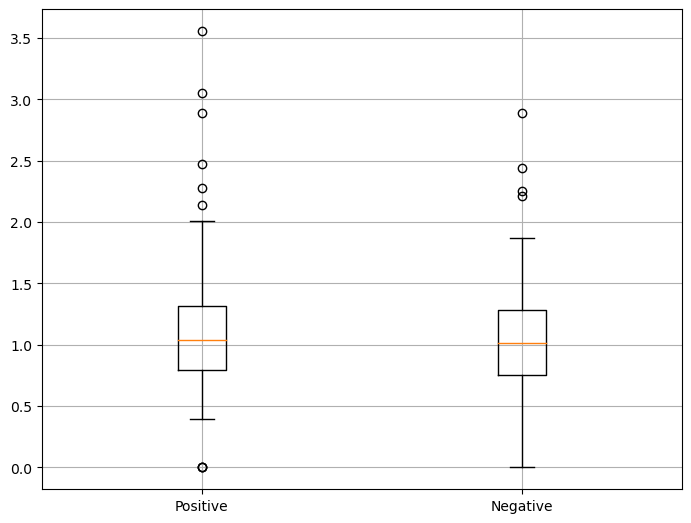

In [62]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [108]:
def compute_accuracy(y_true, y_pred):
    # 1 for the same - distance is smaller than 0.5, 0 for the different
    pred = y_pred.flatten() < 0.5
    y_pred.flat
    return np.mean(pred == y_true)

In [109]:
y_pred_test = euclidean_distance((left_image_feature_vectors, right_image_feature_vectors)).numpy().flatten()
test_accuracy = compute_accuracy(test_labels, y_pred_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

Test accuracy: 54.00%
